In [ ]:
# Intelligent Systems - Assignment 1

- Author: Tim Hrovat
- Student no.: 63230112
- Date: 11. 1. 2026

## Introduction

This section imports the essential libraries for running my solutions.

In [30]:
import sys
# uncomment the following line if any of the packages are not installed
!{sys.executable} -m pip install pandas numpy matplotlib scikit-learn seaborn IPython torch transformers datasets 'accelerate>=0.26.0'

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from IPython.display import display, HTML
import os
import torch
from torch.utils.data import Dataset, DataLoader as TorchDataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import Dataset as HFDataset
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from sentence_transformers import models as st_models
from torch.utils.data import DataLoader as STDataLoader

# sklearn sometimes fires unnecessary warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'
sns.set_style('whitegrid')

## Load Data

In [20]:
class DataLoader:
    """Class for loading and initial processing of JSONL data"""
    
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.train_data = None
        self.test_data = None
    
    def load_jsonl(self, filepath):
        """Load JSONL file and return list of dictionaries"""
        print(f"Loading data from {filepath}")
        data = []
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line.strip()))
        return data
    
    def load_all(self):
        """Load both train and test datasets"""
        self.train_data = self.load_jsonl(self.train_path)
        self.test_data = self.load_jsonl(self.test_path)
        print(f"Loaded {len(self.train_data)} training samples and {len(self.test_data)} test samples\n")
        return self.train_data, self.test_data

## Task 1

### Implementation

In [21]:
class Task1:
    """Task 1: Data Preparation and Exploration"""
    
    def __init__(self, train_data, test_data):
        self.train_raw = train_data
        self.test_raw = test_data
        self.train_df = None
        self.val_df = None
        self.test_df = None
        self.full_train_df = None
        
    def prepare_data(self, binary_labels=True):
        """
        Transform raw data into DataFrame format
        For English dataset: premise, hypothesis, label
        If binary_labels=True, transform to binary: 1=Contradiction, 0=Not Contradiction
        """
        print("Preparing and formatting data")
        
        def process_dataset(data):
            processed = []
            for item in data:
                processed.append({
                    'premise': item.get('premise', ''),
                    'hypothesis': item.get('hypothesis', ''),
                    'label': item.get('label', '')
                })
            return pd.DataFrame(processed)
        
        train_df = process_dataset(self.train_raw)
        test_df = process_dataset(self.test_raw)
        
        if binary_labels:
            train_df['binary_label'] = (train_df['label'] == 'Contradiction').astype(int)
            test_df['binary_label'] = (test_df['label'] == 'Contradiction').astype(int)
        
        self.full_train_df = train_df
        self.test_df = test_df
        
        train_df, val_df = train_test_split(
            train_df, 
            test_size=0.15, 
            random_state=42, 
            stratify=train_df['binary_label']
        )
        
        self.train_df = train_df.reset_index(drop=True)
        self.val_df = val_df.reset_index(drop=True)
        
        print(f"Train set: {len(self.train_df)} samples")
        print(f"Validation set: {len(self.val_df)} samples")
        print(f"Test set: {len(self.test_df)} samples\n")
        
        return self.train_df, self.val_df, self.test_df
    
    def exploratory_analysis(self):
        """Perform exploratory data analysis"""
        print("Performing exploratory data analysis\n")
        
        df = self.full_train_df.copy()
        
        missing_values = df.isnull().sum()
        duplicates = df.duplicated().sum()
        
        df['premise_length'] = df['premise'].str.len()
        df['hypothesis_length'] = df['hypothesis'].str.len()
        df['premise_words'] = df['premise'].str.split().str.len()
        df['hypothesis_words'] = df['hypothesis'].str.split().str.len()
        
        analysis_results = {
            'total_samples': len(df),
            'missing_values': missing_values.to_dict(),
            'duplicate_entries': duplicates,
            'label_distribution': df['binary_label'].value_counts().to_dict(),
            'class_balance': {
                'contradiction': (df['binary_label'] == 1).sum(),
                'not_contradiction': (df['binary_label'] == 0).sum(),
                'contradiction_pct': ((df['binary_label'] == 1).sum() / len(df) * 100)
            },
            'premise_stats': {
                'mean_chars': df['premise_length'].mean(),
                'median_chars': df['premise_length'].median(),
                'mean_words': df['premise_words'].mean(),
                'median_words': df['premise_words'].median()
            },
            'hypothesis_stats': {
                'mean_chars': df['hypothesis_length'].mean(),
                'median_chars': df['hypothesis_length'].median(),
                'mean_words': df['hypothesis_words'].mean(),
                'median_words': df['hypothesis_words'].median()
            }
        }
        
        return analysis_results, df
    
    def visualize_data(self, df, analysis_results):
        """Create visualizations for data exploration"""
        print("Generating visualizations\n")
        
        fig, ax = plt.subplots(figsize=(12, 6))
        label_counts = df['binary_label'].value_counts().sort_index()
        label_names = ['Not Contradiction', 'Contradiction']
        ax.bar(range(len(label_counts)), label_counts.values, color=['#3498db', '#e74c3c'])
        ax.set_title('Binary Label Distribution', fontsize=14, fontweight='bold')
        ax.set_ylabel('Count')
        ax.set_xticks(range(len(label_counts)))
        ax.set_xticklabels(label_names, rotation=45)
        for i, v in enumerate(label_counts.values):
            ax.text(i, v + 50, str(v), ha='center', fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(df['premise_length'], bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
        ax.axvline(df['premise_length'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax.axvline(df['premise_length'].median(), color='blue', linestyle='--', linewidth=2, label='Median')
        ax.set_title('Premise Length Distribution (Characters)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(df['hypothesis_length'], bins=50, color='#f39c12', alpha=0.7, edgecolor='black')
        ax.axvline(df['hypothesis_length'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax.axvline(df['hypothesis_length'].median(), color='blue', linestyle='--', linewidth=2, label='Median')
        ax.set_title('Hypothesis Length Distribution (Characters)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(df['premise_words'], bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
        ax.axvline(df['premise_words'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax.set_title('Premise Length Distribution (Words)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Word Count')
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(df['hypothesis_words'], bins=30, color='#1abc9c', alpha=0.7, edgecolor='black')
        ax.axvline(df['hypothesis_words'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax.set_title('Hypothesis Length Distribution (Words)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Word Count')
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        label_by_length = df.groupby(pd.cut(df['premise_length'], bins=5))['binary_label'].value_counts().unstack()
        label_by_length.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
        ax.set_title('Label Distribution by Premise Length', fontsize=14, fontweight='bold')
        ax.set_xlabel('Premise Length Range')
        ax.set_ylabel('Count')
        ax.legend(title='Label', labels=['Not Contradiction', 'Contradiction'])
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()
        
        html_table = f"""
        <h3>Data Analysis Summary</h3>
        <table border="1" style="border-collapse: collapse; width: 100%; margin: 20px 0;">
            <tr style="background-color: #3498db; color: white;">
                <th style="padding: 10px;">Metric</th>
                <th style="padding: 10px;">Value</th>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Total Samples</b></td>
                <td style="padding: 8px;">{analysis_results['total_samples']}</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 8px;"><b>Duplicate Entries</b></td>
                <td style="padding: 8px;">{analysis_results['duplicate_entries']}</td>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Contradiction Samples (1)</b></td>
                <td style="padding: 8px;">{analysis_results['class_balance']['contradiction']}</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 8px;"><b>Not Contradiction Samples (0)</b></td>
                <td style="padding: 8px;">{analysis_results['class_balance']['not_contradiction']}</td>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Contradiction Percentage</b></td>
                <td style="padding: 8px;">{analysis_results['class_balance']['contradiction_pct']:.2f}%</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 8px;"><b>Mean Premise Length (chars)</b></td>
                <td style="padding: 8px;">{analysis_results['premise_stats']['mean_chars']:.1f}</td>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Mean Hypothesis Length (chars)</b></td>
                <td style="padding: 8px;">{analysis_results['hypothesis_stats']['mean_chars']:.1f}</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 8px;"><b>Mean Premise Length (words)</b></td>
                <td style="padding: 8px;">{analysis_results['premise_stats']['mean_words']:.1f}</td>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Mean Hypothesis Length (words)</b></td>
                <td style="padding: 8px;">{analysis_results['hypothesis_stats']['mean_words']:.1f}</td>
            </tr>
        </table>
        """
        
        display(HTML(html_table))

### Test

TASK 1: DATA PREPARATION AND EXPLORATION

Loading data from data/English dataset/train.jsonl
Loading data from data/English dataset/test.jsonl
Loaded 7191 training samples and 2091 test samples

Preparing and formatting data
Train set: 6112 samples
Validation set: 1079 samples
Test set: 2091 samples

Performing exploratory data analysis

Generating visualizations



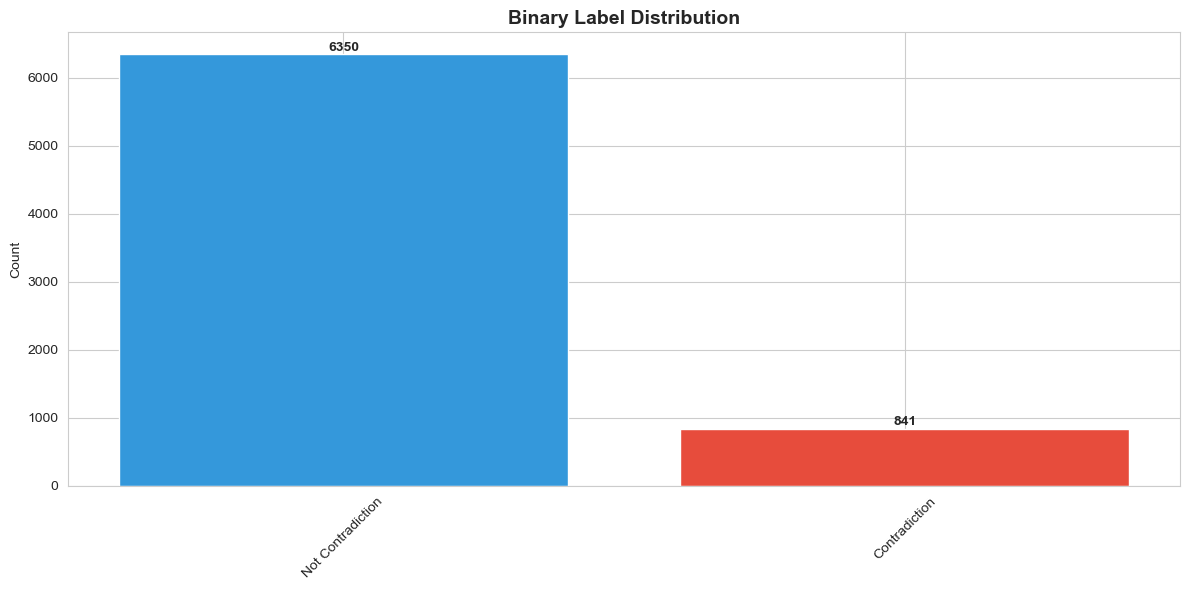

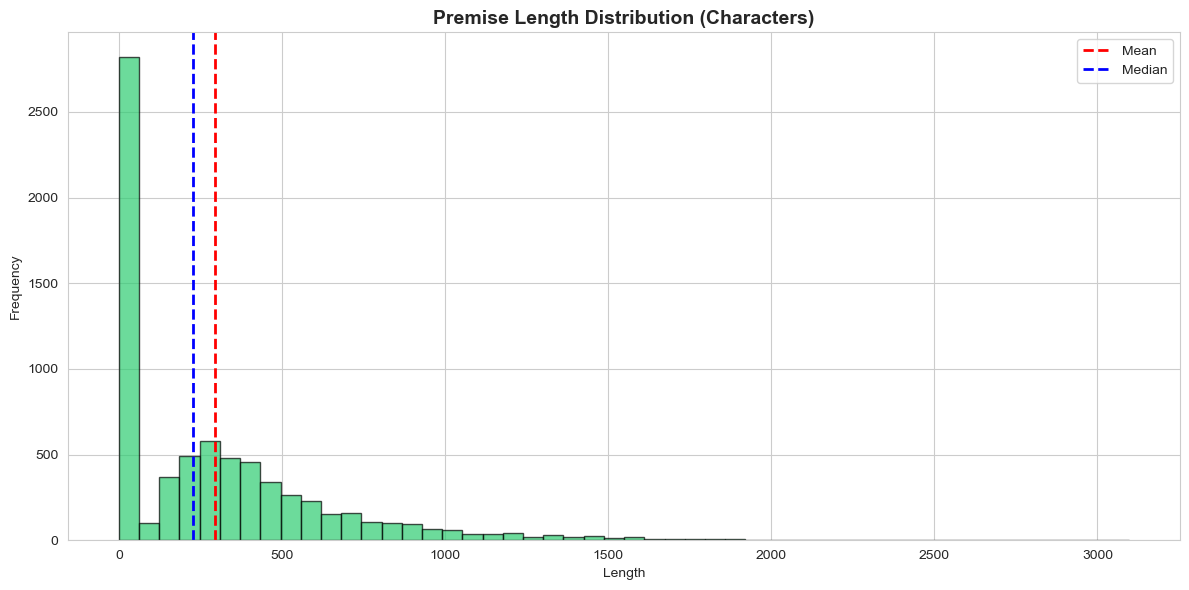

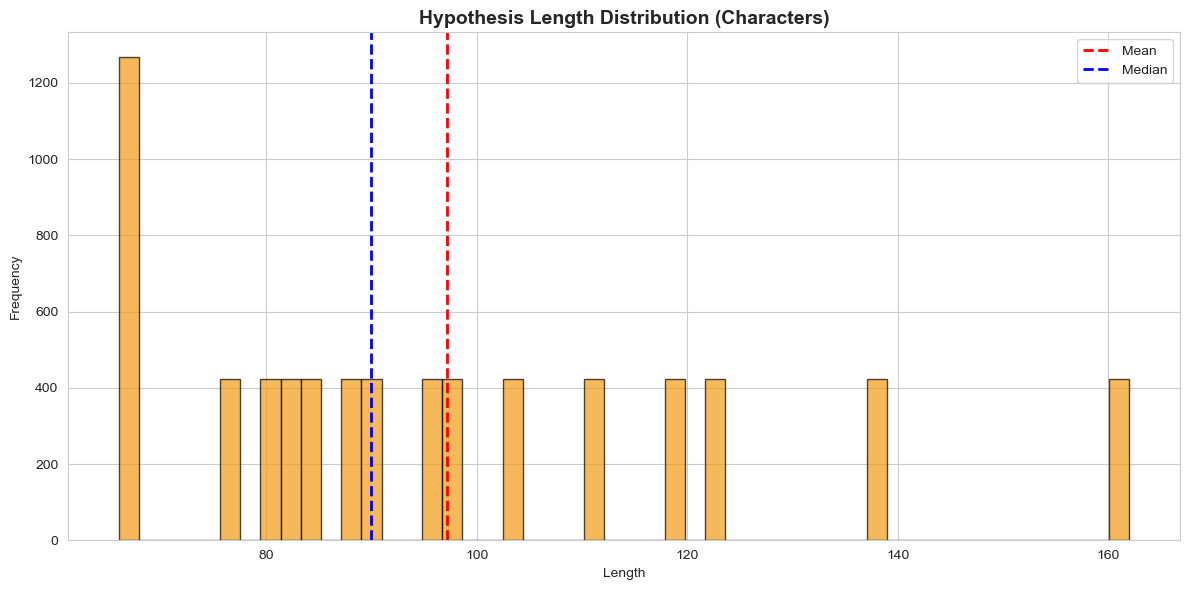

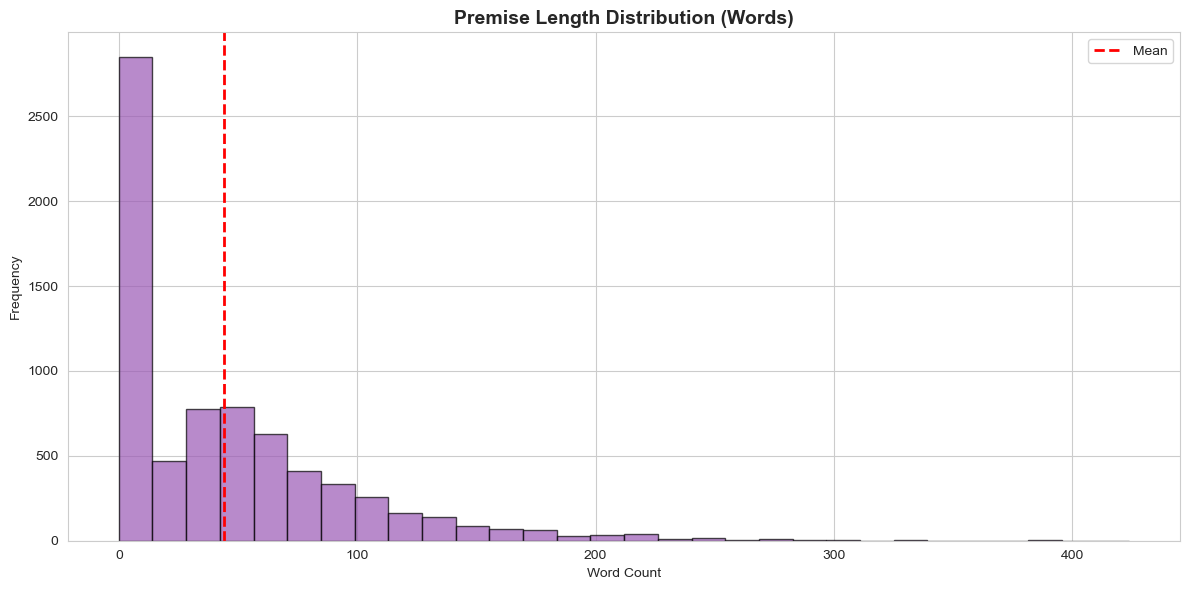

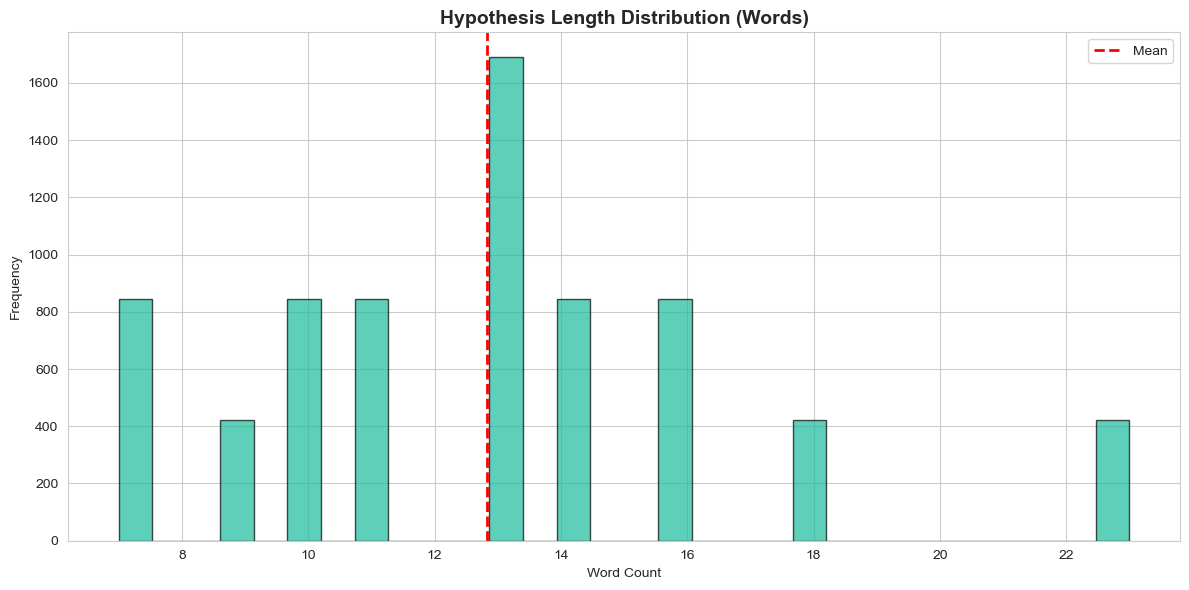

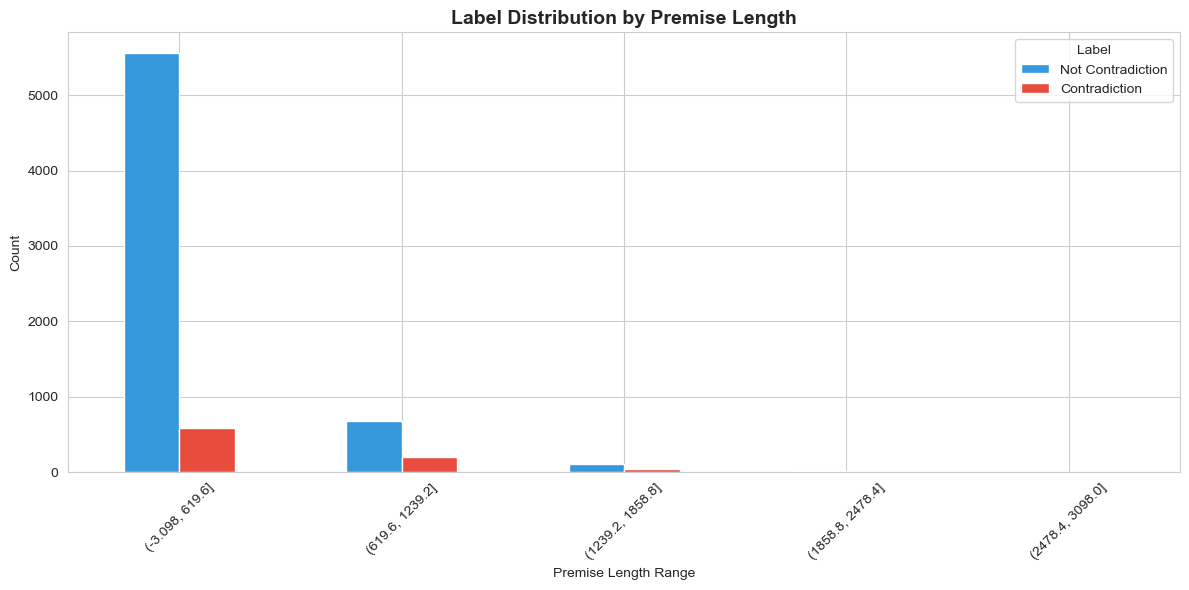

Metric,Value
Total Samples,7191
Duplicate Entries,2882
Contradiction Samples (1),841
Not Contradiction Samples (0),6350
Contradiction Percentage,11.70%
Mean Premise Length (chars),296.3
Mean Hypothesis Length (chars),97.2
Mean Premise Length (words),44.1
Mean Hypothesis Length (words),12.8


TASK 1 COMPLETED SUCCESSFULLY



In [22]:
def task_1_test():
    """Test function for Task 1: Data Preparation and Exploration"""
    print("="*80)
    print("TASK 1: DATA PREPARATION AND EXPLORATION")
    print("="*80)
    print()
    
    loader = DataLoader(
        train_path='data/English dataset/train.jsonl',
        test_path='data/English dataset/test.jsonl'
    )
    train_data, test_data = loader.load_all()
    
    task1 = Task1(train_data, test_data)
    
    train_df, val_df, test_df = task1.prepare_data(binary_labels=True)
    
    analysis_results, df_with_stats = task1.exploratory_analysis()
    
    task1.visualize_data(df_with_stats, analysis_results)
    
    print("="*80)
    print("TASK 1 COMPLETED SUCCESSFULLY")
    print("="*80)
    print()
    
    return task1, train_df, val_df, test_df

task_1_test();

## task 2

### Implementation

In [24]:
class Task2:
    """Task 2: Traditional Machine Learning Models"""
    
    def __init__(self, train_df, val_df, test_df):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.vectorizer = None
        self.models = {}
        self.results = {}
        
    def prepare_text_features(self, max_features=5000):
        """Create text representations using TF-IDF"""
        print("Creating TF-IDF features")
        
        self.train_df['combined_text'] = self.train_df['premise'] + ' [SEP] ' + self.train_df['hypothesis']
        self.val_df['combined_text'] = self.val_df['premise'] + ' [SEP] ' + self.val_df['hypothesis']
        self.test_df['combined_text'] = self.test_df['premise'] + ' [SEP] ' + self.test_df['hypothesis']
        
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95,
            sublinear_tf=True
        )
        
        X_train = self.vectorizer.fit_transform(self.train_df['combined_text'])
        X_val = self.vectorizer.transform(self.val_df['combined_text'])
        X_test = self.vectorizer.transform(self.test_df['combined_text'])
        
        y_train = self.train_df['binary_label'].values
        y_val = self.val_df['binary_label'].values
        y_test = self.test_df['binary_label'].values
        
        print(f"Feature matrix shape: {X_train.shape}\n")
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def train_logistic_regression(self, X_train, y_train, X_val, y_val):
        """Train Logistic Regression with hyperparameter tuning"""
        print("Training Logistic Regression")
        
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'max_iter': [1000]
        }
        
        lr = LogisticRegression(random_state=42, solver='lbfgs')
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(lr, param_grid, cv=3, scoring='f1', n_jobs=1, verbose=0)
            grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        self.models['Logistic Regression'] = best_model
        
        y_pred_val = best_model.predict(X_val)
        y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
        
        metrics = self._calculate_metrics(y_val, y_pred_val, y_pred_proba_val)
        self.results['Logistic Regression'] = metrics
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Validation F1: {metrics['f1']:.4f}\n")
        
        return best_model
    
    def train_random_forest(self, X_train, y_train, X_val, y_val):
        """Train Random Forest with hyperparameter tuning"""
        print("Training Random Forest")
        
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        
        rf = RandomForestClassifier(random_state=42, n_jobs=-1)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=1, verbose=0)
            grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        self.models['Random Forest'] = best_model
        
        y_pred_val = best_model.predict(X_val)
        y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
        
        metrics = self._calculate_metrics(y_val, y_pred_val, y_pred_proba_val)
        self.results['Random Forest'] = metrics
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Validation F1: {metrics['f1']:.4f}\n")
        
        return best_model
    
    def train_svm(self, X_train, y_train, X_val, y_val):
        """Train SVM with hyperparameter tuning"""
        print("Training SVM")
        
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'loss': ['hinge', 'squared_hinge']
        }
        
        svm = LinearSVC(random_state=42, max_iter=2000, dual=False)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='f1', n_jobs=1, verbose=0)
            grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        self.models['SVM'] = best_model
        
        y_pred_val = best_model.predict(X_val)
        
        metrics = self._calculate_metrics(y_val, y_pred_val, None)
        self.results['SVM'] = metrics
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Validation F1: {metrics['f1']:.4f}\n")
        
        return best_model
    
    def train_decision_tree(self, X_train, y_train, X_val, y_val):
        """Train Decision Tree with hyperparameter tuning"""
        print("Training Decision Tree")
        
        param_grid = {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
        dt = DecisionTreeClassifier(random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='f1', n_jobs=1, verbose=0)
            grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        self.models['Decision Tree'] = best_model
        
        y_pred_val = best_model.predict(X_val)
        y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
        
        metrics = self._calculate_metrics(y_val, y_pred_val, y_pred_proba_val)
        self.results['Decision Tree'] = metrics
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Validation F1: {metrics['f1']:.4f}\n")
        
        return best_model
    
    def _calculate_metrics(self, y_true, y_pred, y_pred_proba=None):
        """Calculate evaluation metrics"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0)
        }
        
        if y_pred_proba is not None:
            metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
        
        return metrics
    
    def evaluate_on_test(self, X_test, y_test):
        """Evaluate all models on test set"""
        print("Evaluating models on test set\n")
        
        test_results = {}
        
        for model_name, model in self.models.items():
            y_pred = model.predict(X_test)
            
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                metrics = self._calculate_metrics(y_test, y_pred, y_pred_proba)
            else:
                metrics = self._calculate_metrics(y_test, y_pred, None)
            
            test_results[model_name] = metrics
            print(f"{model_name} - Test F1: {metrics['f1']:.4f}, Accuracy: {metrics['accuracy']:.4f}")
        
        print()
        return test_results
    
    def visualize_results(self, val_results, test_results):
        """Visualize model comparison"""
        print("Generating performance visualizations\n")
        
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        model_names = list(val_results.keys())
        
        x = np.arange(len(model_names))
        width = 0.2
        
        fig, ax = plt.subplots(figsize=(14, 6))
        for i, metric in enumerate(metrics):
            val_scores = [val_results[m][metric] for m in model_names]
            ax.bar(x + i * width, val_scores, width, label=metric.capitalize())
        
        ax.set_xlabel('Models', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Validation Set Performance', fontsize=14, fontweight='bold')
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(14, 6))
        for i, metric in enumerate(metrics):
            test_scores = [test_results[m][metric] for m in model_names]
            ax.bar(x + i * width, test_scores, width, label=metric.capitalize())
        
        ax.set_xlabel('Models', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Test Set Performance', fontsize=14, fontweight='bold')
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        results_df = pd.DataFrame({
            'Model': model_names,
            'Val_Accuracy': [val_results[m]['accuracy'] for m in model_names],
            'Val_F1': [val_results[m]['f1'] for m in model_names],
            'Test_Accuracy': [test_results[m]['accuracy'] for m in model_names],
            'Test_F1': [test_results[m]['f1'] for m in model_names]
        })
        
        html_table = results_df.to_html(index=False, float_format=lambda x: f'{x:.4f}')
        html_table = f"<h3>Model Performance Summary</h3>{html_table}"
        html_table = html_table.replace('<table', '<table style="border-collapse: collapse; width: 100%;"')
        html_table = html_table.replace('<th>', '<th style="background-color: #3498db; color: white; padding: 10px;">')
        html_table = html_table.replace('<td>', '<td style="padding: 8px; border: 1px solid #ddd;">')
        
        display(HTML(html_table))

### Test

TASK 2: TRADITIONAL MACHINE LEARNING

Loading data from data/English dataset/train.jsonl
Loading data from data/English dataset/test.jsonl
Loaded 7191 training samples and 2091 test samples

Preparing and formatting data
Train set: 6112 samples
Validation set: 1079 samples
Test set: 2091 samples

Creating TF-IDF features
Feature matrix shape: (6112, 5000)

Training Logistic Regression
Best parameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2'}
Validation F1: 0.8240

Training Random Forest
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Validation F1: 0.8621

Training SVM
Best parameters: {'C': 10.0, 'loss': 'squared_hinge'}
Validation F1: 0.8216

Training Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Validation F1: 0.7917

Evaluating models on test set

Logistic Regression - Test F1: 0.7756, Accuracy: 0.9560
Random Forest - Test F1: 0.7979, Accuracy: 0.9627
SVM - Test F1: 0.78

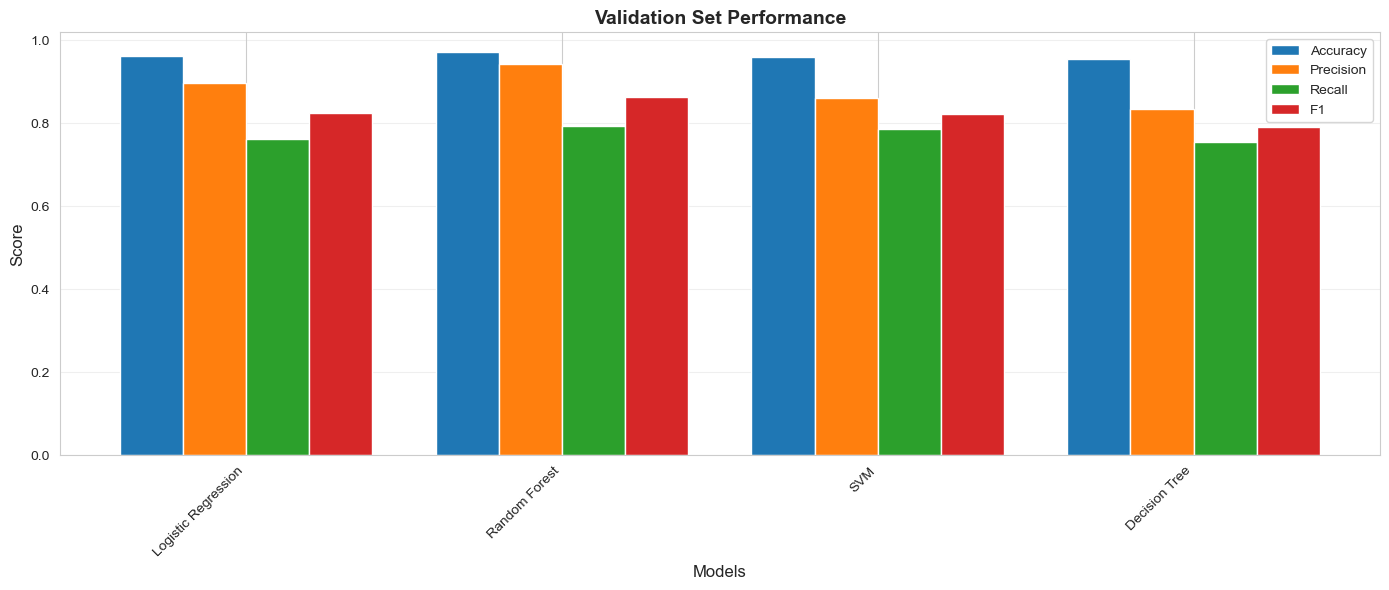

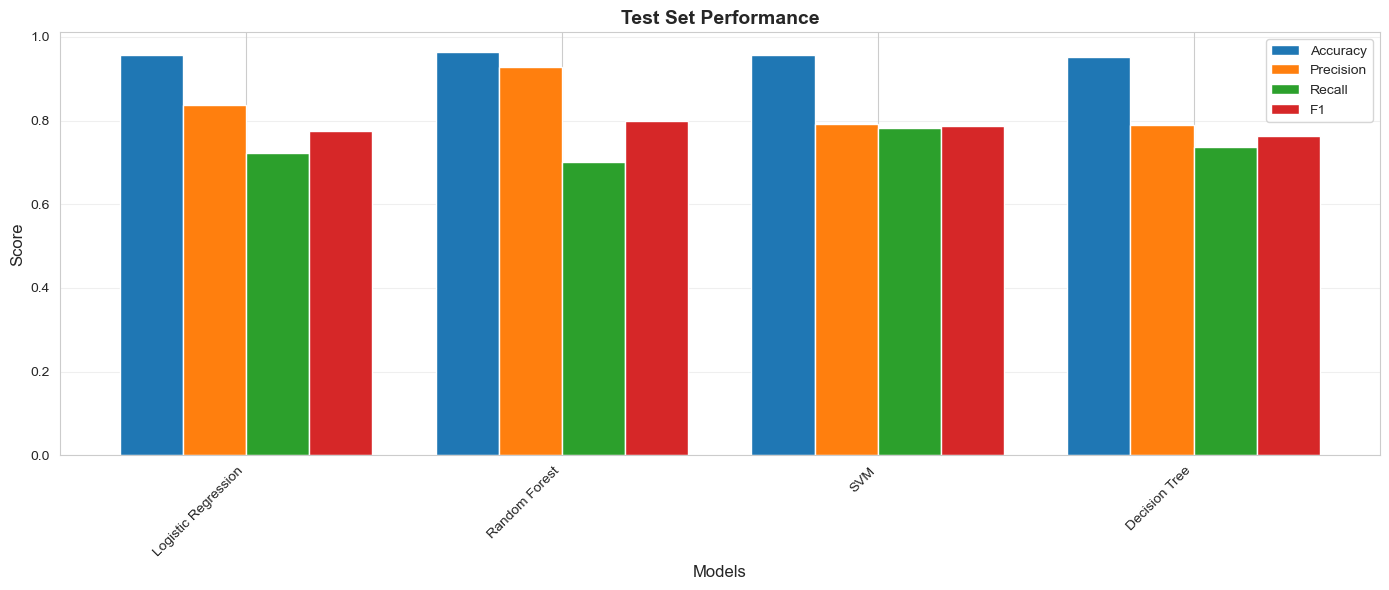

Model,Val_Accuracy,Val_F1,Test_Accuracy,Test_F1
Logistic Regression,0.9620,0.8240,0.9560,0.7756
Random Forest,0.9703,0.8621,0.9627,0.7979
SVM,0.9601,0.8216,0.9555,0.7872
Decision Tree,0.9537,0.7917,0.9517,0.7624


TASK 2 COMPLETED SUCCESSFULLY



In [25]:
def task_2_test():
    """Test function for Task 2: Traditional Machine Learning Models"""
    print("="*80)
    print("TASK 2: TRADITIONAL MACHINE LEARNING")
    print("="*80)
    print()
    
    loader = DataLoader(
        train_path='data/English dataset/train.jsonl',
        test_path='data/English dataset/test.jsonl'
    )
    train_data, test_data = loader.load_all()
    
    task1 = Task1(train_data, test_data)
    train_df, val_df, test_df = task1.prepare_data(binary_labels=True)
    
    task2 = Task2(train_df, val_df, test_df)
    
    X_train, X_val, X_test, y_train, y_val, y_test = task2.prepare_text_features(
        max_features=5000
    )
    
    task2.train_logistic_regression(X_train, y_train, X_val, y_val)
    task2.train_random_forest(X_train, y_train, X_val, y_val)
    task2.train_svm(X_train, y_train, X_val, y_val)
    task2.train_decision_tree(X_train, y_train, X_val, y_val)
    
    test_results = task2.evaluate_on_test(X_test, y_test)
    
    task2.visualize_results(task2.results, test_results)
    
    print("="*80)
    print("TASK 2 COMPLETED SUCCESSFULLY")
    print("="*80)
    print()
    
    return task2, test_results

task_2_test();

## Task 3

### Implementation

In [27]:
class Task3:
    """Task 3: Transformer-based Classifier"""
    
    def __init__(self, train_df, val_df, test_df, model_name='nlpaueb/legal-bert-base-uncased'):
        self.train_df = train_df.copy()
        self.val_df = val_df.copy()
        self.test_df = test_df.copy()
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.trainer = None
        self.results = {}
        
    def prepare_datasets(self, max_length=512):
        """Prepare datasets for transformer training"""
        print(f"Preparing datasets for {self.model_name}")
        print(f"Max sequence length: {max_length}")
        
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        
        def create_hf_dataset(df):
            return HFDataset.from_dict({
                'premise': df['premise'].tolist(),
                'hypothesis': df['hypothesis'].tolist(),
                'label': df['binary_label'].tolist()
            })
        
        train_dataset = create_hf_dataset(self.train_df)
        val_dataset = create_hf_dataset(self.val_df)
        test_dataset = create_hf_dataset(self.test_df)
        
        def tokenize_function(examples):
            return self.tokenizer(
                examples['premise'],
                examples['hypothesis'],
                truncation=True,
                padding='max_length',
                max_length=max_length
            )
        
        print("Tokenizing datasets...")
        train_dataset = train_dataset.map(tokenize_function, batched=True)
        val_dataset = val_dataset.map(tokenize_function, batched=True)
        test_dataset = test_dataset.map(tokenize_function, batched=True)
        
        train_dataset = train_dataset.remove_columns(['premise', 'hypothesis'])
        val_dataset = val_dataset.remove_columns(['premise', 'hypothesis'])
        test_dataset = test_dataset.remove_columns(['premise', 'hypothesis'])
        
        train_dataset.set_format('torch')
        val_dataset.set_format('torch')
        test_dataset.set_format('torch')
        
        print(f"Train dataset: {len(train_dataset)} samples")
        print(f"Validation dataset: {len(val_dataset)} samples")
        print(f"Test dataset: {len(test_dataset)} samples\n")
        
        return train_dataset, val_dataset, test_dataset
    
    def compute_metrics(self, eval_pred):
        """Compute metrics for evaluation"""
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        
        return {
            'accuracy': accuracy_score(labels, predictions),
            'precision': precision_score(labels, predictions, zero_division=0),
            'recall': recall_score(labels, predictions, zero_division=0),
            'f1': f1_score(labels, predictions, zero_division=0)
        }
    
    def train_model(self, train_dataset, val_dataset, 
                    num_epochs=3, batch_size=16, learning_rate=2e-5,
                    warmup_steps=500, weight_decay=0.01,
                    output_dir='./results_task3'):
        """Train the transformer model"""
        print(f"Training {self.model_name}")
        print(f"Epochs: {num_epochs}, Batch size: {batch_size}, Learning rate: {learning_rate}\n")
        
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=2
        )
        
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            warmup_steps=warmup_steps,
            weight_decay=weight_decay,
            logging_dir=f'{output_dir}/logs',
            logging_steps=100,
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1',
            greater_is_better=True,
            save_total_limit=2,
            report_to='none',
            seed=42
        )
        
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )
        
        print("Starting training...")
        self.trainer.train()
        print("Training completed\n")
        
        return self.trainer
    
    def evaluate_model(self, test_dataset):
        """Evaluate model on test set"""
        print("Evaluating on test set...")
        
        test_results = self.trainer.evaluate(test_dataset)
        
        predictions = self.trainer.predict(test_dataset)
        pred_labels = np.argmax(predictions.predictions, axis=1)
        true_labels = predictions.label_ids
        
        metrics = {
            'accuracy': accuracy_score(true_labels, pred_labels),
            'precision': precision_score(true_labels, pred_labels, zero_division=0),
            'recall': recall_score(true_labels, pred_labels, zero_division=0),
            'f1': f1_score(true_labels, pred_labels, zero_division=0)
        }
        
        pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
        metrics['roc_auc'] = roc_auc_score(true_labels, pred_probs)
        
        self.results = metrics
        
        print(f"\nTest Results:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        print(f"ROC AUC: {metrics['roc_auc']:.4f}\n")
        
        cm = confusion_matrix(true_labels, pred_labels)
        
        return metrics, cm, pred_labels, true_labels
    
    def visualize_results(self, cm, task2_results=None):
        """Visualize transformer model results"""
        print("Generating visualizations\n")
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Not Contradiction', 'Contradiction'],
                    yticklabels=['Not Contradiction', 'Contradiction'])
        ax.set_title('Confusion Matrix - Transformer Model', fontsize=14, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=12)
        ax.set_xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        if task2_results is not None:
            fig, ax = plt.subplots(figsize=(14, 6))
            
            models = list(task2_results.keys()) + ['Legal-BERT']
            metrics_list = ['accuracy', 'precision', 'recall', 'f1']
            
            x = np.arange(len(models))
            width = 0.2
            
            for i, metric in enumerate(metrics_list):
                scores = []
                for model in models[:-1]:
                    scores.append(task2_results[model][metric])
                scores.append(self.results[metric])
                
                ax.bar(x + i * width, scores, width, label=metric.capitalize())
            
            ax.set_xlabel('Models', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
            ax.set_title('Model Comparison: Traditional ML vs Transformer', fontsize=14, fontweight='bold')
            ax.set_xticks(x + width * 1.5)
            ax.set_xticklabels(models, rotation=45, ha='right')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        results_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
            'Score': [
                self.results['accuracy'],
                self.results['precision'],
                self.results['recall'],
                self.results['f1'],
                self.results['roc_auc']
            ]
        })
        
        html_table = results_df.to_html(index=False, float_format=lambda x: f'{x:.4f}')
        html_table = f"<h3>Transformer Model Performance</h3>{html_table}"
        html_table = html_table.replace('<table', '<table style="border-collapse: collapse; width: 100%;"')
        html_table = html_table.replace('<th>', '<th style="background-color: #3498db; color: white; padding: 10px;">')
        html_table = html_table.replace('<td>', '<td style="padding: 8px; border: 1px solid #ddd;">')
        
        display(HTML(html_table))
    
    def compare_with_traditional_ml(self, task2_results):
        """Create detailed comparison table"""
        comparison_data = []
        
        for model_name, metrics in task2_results.items():
            comparison_data.append({
                'Model': model_name,
                'Type': 'Traditional ML',
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1': metrics['f1'],
                'ROC AUC': metrics.get('roc_auc', 'N/A')
            })
        
        comparison_data.append({
            'Model': 'Legal-BERT',
            'Type': 'Transformer',
            'Accuracy': self.results['accuracy'],
            'Precision': self.results['precision'],
            'Recall': self.results['recall'],
            'F1': self.results['f1'],
            'ROC AUC': self.results['roc_auc']
        })
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('F1', ascending=False).reset_index(drop=True)
        
        html_table = comparison_df.to_html(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else x)
        html_table = f"<h3>Comprehensive Model Comparison</h3>{html_table}"
        html_table = html_table.replace('<table', '<table style="border-collapse: collapse; width: 100%;"')
        html_table = html_table.replace('<th>', '<th style="background-color: #2ecc71; color: white; padding: 10px;">')
        html_table = html_table.replace('<td>', '<td style="padding: 8px; border: 1px solid #ddd;">')
        
        display(HTML(html_table))
        
        return comparison_df

### Test

In [ ]:
def task_3_test():
    """Test function for Task 3: Transformer-based Classifier"""
    print("="*80)
    print("TASK 3: TRANSFORMER-BASED CLASSIFIER")
    print("="*80)
    print()
    
    loader = DataLoader(
        train_path='data/English dataset/train.jsonl',
        test_path='data/English dataset/test.jsonl'
    )
    train_data, test_data = loader.load_all()
    
    task1 = Task1(train_data, test_data)
    train_df, val_df, test_df = task1.prepare_data(binary_labels=True)
    
    print("Training Task 2 models for comparison...")
    task2 = Task2(train_df, val_df, test_df)
    X_train, X_val, X_test, y_train, y_val, y_test = task2.prepare_text_features(max_features=5000)
    task2.train_logistic_regression(X_train, y_train, X_val, y_val)
    task2.train_random_forest(X_train, y_train, X_val, y_val)
    task2.train_svm(X_train, y_train, X_val, y_val)
    task2.train_decision_tree(X_train, y_train, X_val, y_val)
    task2_results = task2.evaluate_on_test(X_test, y_test)
    
    task3 = Task3(train_df, val_df, test_df, model_name='nlpaueb/legal-bert-base-uncased')
    
    train_dataset, val_dataset, test_dataset = task3.prepare_datasets(max_length=512)
    
    task3.train_model(
        train_dataset, 
        val_dataset,
        num_epochs=3,
        batch_size=16,
        learning_rate=2e-5
    )
    
    metrics, cm, pred_labels, true_labels = task3.evaluate_model(test_dataset)
    
    task3.visualize_results(cm, task2_results)
    
    comparison_df = task3.compare_with_traditional_ml(task2_results)
    
    print("="*80)
    print("TASK 3 COMPLETED SUCCESSFULLY")
    print("="*80)
    print()
    
    return task3, metrics

task_3_test();

TASK 3: TRANSFORMER-BASED CLASSIFIER

Loading data from data/English dataset/train.jsonl
Loading data from data/English dataset/test.jsonl
Loaded 7191 training samples and 2091 test samples

Preparing and formatting data
Train set: 6112 samples
Validation set: 1079 samples
Test set: 2091 samples

Training Task 2 models for comparison...
Creating TF-IDF features
Feature matrix shape: (6112, 5000)

Training Logistic Regression
Best parameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2'}
Validation F1: 0.8240

Training Random Forest
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Validation F1: 0.8621

Training SVM
Best parameters: {'C': 10.0, 'loss': 'squared_hinge'}
Validation F1: 0.8216

Training Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Validation F1: 0.7917

Evaluating models on test set

Logistic Regression - Test F1: 0.7756, Accuracy: 0.9560
Random Forest - Test F1: 0.7

## Task 4

### Implementation

In [ ]:
class Task4:
    """Task 4: Sentence Embedding Model for Contradiction Search"""
    
    def __init__(self, train_df, val_df, test_df, base_model='nlpaueb/legal-bert-base-uncased'):
        self.train_df = train_df.copy()
        self.val_df = val_df.copy()
        self.test_df = test_df.copy()
        self.base_model = base_model
        self.model = None
        self.results = {}
        self.corpus_embeddings = None
        self.corpus_texts = None
        
    def prepare_training_data(self):
        """Prepare data for sentence transformer training"""
        print("Preparing training data for sentence transformer")
        
        train_examples = []
        for idx, row in self.train_df.iterrows():
            label = float(row['binary_label'])
            train_examples.append(InputExample(
                texts=[row['premise'], row['hypothesis']], 
                label=label
            ))
        
        val_examples = []
        for idx, row in self.val_df.iterrows():
            label = float(row['binary_label'])
            val_examples.append(InputExample(
                texts=[row['premise'], row['hypothesis']], 
                label=label
            ))
        
        print(f"Created {len(train_examples)} training examples")
        print(f"Created {len(val_examples)} validation examples\n")
        
        return train_examples, val_examples
    
    def train_sentence_transformer(self, train_examples, val_examples, 
                                   num_epochs=3, batch_size=16, 
                                   output_dir='./sentence_transformer_model'):
        """Train or fine-tune a sentence transformer model"""
        print(f"Training Sentence Transformer based on {self.base_model}")
        print(f"Epochs: {num_epochs}, Batch size: {batch_size}\n")
        
        word_embedding_model = st_models.Transformer(self.base_model, max_seq_length=512)
        pooling_model = st_models.Pooling(word_embedding_model.get_word_embedding_dimension())
        
        self.model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
        
        train_dataloader = STDataLoader(train_examples, shuffle=True, batch_size=batch_size)
        
        train_loss = losses.CosineSimilarityLoss(self.model)
        
        evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(
            val_examples, name='validation'
        )
        
        warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
        
        print("Starting training...")
        self.model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            evaluator=evaluator,
            epochs=num_epochs,
            evaluation_steps=500,
            warmup_steps=warmup_steps,
            output_path=output_dir,
            show_progress_bar=True
        )
        
        print("Training completed\n")
        
        return self.model
    
    def create_corpus_embeddings(self):
        """Create embeddings for all sections in the dataset"""
        print("Creating corpus embeddings for retrieval")
        
        all_df = pd.concat([self.train_df, self.val_df, self.test_df], ignore_index=True)
        
        all_premises = all_df['premise'].unique().tolist()
        all_hypotheses = all_df['hypothesis'].unique().tolist()
        
        self.corpus_texts = list(set(all_premises + all_hypotheses))
        
        print(f"Encoding {len(self.corpus_texts)} unique text sections...")
        self.corpus_embeddings = self.model.encode(
            self.corpus_texts, 
            convert_to_tensor=True,
            show_progress_bar=True
        )
        
        print(f"Created embeddings with shape: {self.corpus_embeddings.shape}\n")
        
        return self.corpus_embeddings, self.corpus_texts
    
    def retrieve_contradictions(self, query_text, k=5):
        """Retrieve top k most similar (potentially contradicting) sections"""
        query_embedding = self.model.encode(query_text, convert_to_tensor=True)
        
        cos_scores = torch.nn.functional.cosine_similarity(
            query_embedding.unsqueeze(0), 
            self.corpus_embeddings
        )
        
        top_results = torch.topk(cos_scores, k=min(k, len(self.corpus_texts)))
        
        results = []
        for score, idx in zip(top_results[0], top_results[1]):
            results.append({
                'text': self.corpus_texts[idx],
                'similarity_score': score.item(),
                'index': idx.item()
            })
        
        return results
    
    def evaluate_retrieval(self, test_df, k_values=[1, 5, 10]):
        """Evaluate retrieval performance"""
        print("Evaluating retrieval performance")
        
        results = {k: {'recall': 0, 'precision': 0, 'total': 0} for k in k_values}
        
        contradiction_pairs = test_df[test_df['binary_label'] == 1]
        
        print(f"Evaluating on {len(contradiction_pairs)} contradiction pairs\n")
        
        for idx, row in contradiction_pairs.iterrows():
            query = row['premise']
            true_contradiction = row['hypothesis']
            
            for k in k_values:
                retrieved = self.retrieve_contradictions(query, k=k)
                retrieved_texts = [r['text'] for r in retrieved]
                
                if true_contradiction in retrieved_texts:
                    results[k]['recall'] += 1
                
                results[k]['total'] += 1
        
        for k in k_values:
            if results[k]['total'] > 0:
                results[k]['recall'] = results[k]['recall'] / results[k]['total']
        
        self.results = results
        
        print("Retrieval Results:")
        for k in k_values:
            print(f"Recall@{k}: {results[k]['recall']:.4f}")
        print()
        
        return results
    
    def visualize_results(self):
        """Visualize retrieval performance"""
        print("Generating retrieval visualizations\n")
        
        k_values = sorted(self.results.keys())
        recall_scores = [self.results[k]['recall'] for k in k_values]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(k_values, recall_scores, marker='o', linewidth=2, markersize=8, color='#2ecc71')
        ax.set_xlabel('K (Number of Retrieved Documents)', fontsize=12)
        ax.set_ylabel('Recall Score', fontsize=12)
        ax.set_title('Retrieval Performance: Recall@K', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(k_values)
        
        for k, recall in zip(k_values, recall_scores):
            ax.text(k, recall + 0.01, f'{recall:.3f}', ha='center', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        results_df = pd.DataFrame({
            'K': k_values,
            'Recall': recall_scores
        })
        
        html_table = results_df.to_html(index=False, float_format=lambda x: f'{x:.4f}')
        html_table = f"<h3>Retrieval Performance Metrics</h3>{html_table}"
        html_table = html_table.replace('<table', '<table style="border-collapse: collapse; width: 100%;"')
        html_table = html_table.replace('<th>', '<th style="background-color: #2ecc71; color: white; padding: 10px;">')
        html_table = html_table.replace('<td>', '<td style="padding: 8px; border: 1px solid #ddd;">')
        
        display(HTML(html_table))
    
    def demonstrate_retrieval(self, num_examples=3):
        """Demonstrate retrieval with example queries"""
        print("Demonstrating retrieval with examples\n")
        
        test_contradictions = self.test_df[self.test_df['binary_label'] == 1].head(num_examples)
        
        for idx, row in test_contradictions.iterrows():
            query = row['premise']
            true_contradiction = row['hypothesis']
            
            retrieved = self.retrieve_contradictions(query, k=5)
            
            html = f"""
            <div style="border: 2px solid #3498db; padding: 15px; margin: 20px 0; border-radius: 5px;">
                <h4 style="color: #3498db;">Example Query:</h4>
                <p><b>Query Text:</b> {query[:300]}...</p>
                <p><b>True Contradiction:</b> {true_contradiction[:300]}...</p>
                <h4 style="color: #2ecc71;">Top 5 Retrieved Sections:</h4>
                <ol>
            """
            
            for i, result in enumerate(retrieved):
                color = '#2ecc71' if result['text'] == true_contradiction else '#95a5a6'
                marker = '✓ TRUE MATCH' if result['text'] == true_contradiction else ''
                html += f"""
                    <li style="margin: 10px 0;">
                        <b style="color: {color};">Similarity: {result['similarity_score']:.4f} {marker}</b><br>
                        {result['text'][:200]}...
                    </li>
                """
            
            html += """
                </ol>
            </div>
            """
            
            display(HTML(html))

### Test

In [ ]:
def task_4_test():
    """Test function for Task 4: Sentence Embedding Model for Contradiction Search"""
    print("="*80)
    print("TASK 4: SENTENCE EMBEDDING MODEL FOR CONTRADICTION SEARCH")
    print("="*80)
    print()
    
    loader = DataLoader(
        train_path='data/English dataset/train.jsonl',
        test_path='data/English dataset/test.jsonl'
    )
    train_data, test_data = loader.load_all()
    
    task1 = Task1(train_data, test_data)
    train_df, val_df, test_df = task1.prepare_data(binary_labels=True)
    
    task4 = Task4(train_df, val_df, test_df, base_model='nlpaueb/legal-bert-base-uncased')
    
    train_examples, val_examples = task4.prepare_training_data()
    
    task4.train_sentence_transformer(
        train_examples,
        val_examples,
        num_epochs=3,
        batch_size=16
    )
    
    corpus_embeddings, corpus_texts = task4.create_corpus_embeddings()
    
    retrieval_results = task4.evaluate_retrieval(test_df, k_values=[1, 5, 10, 20])
    
    task4.visualize_results()
    
    task4.demonstrate_retrieval(num_examples=3)
    
    print("="*80)
    print("TASK 4 COMPLETED SUCCESSFULLY")
    print("="*80)
    print()
    
    return task4, retrieval_results